# EDA for US House 1981-2016

This notebook includes exploratory descriptive analysis of all text data from the US House of Representatives between 1981 and 2016. The purpose of this notebook is to provide figures and information for the supplementary materials and appendix of my dissertation. This notebook is also meant ot address an issue identified in previous iterations of analysis, in which a large proportion of speeches were clasified by topic models to have no political meaning. Descriptive analysis here is meant to identify reasons why previous pre-processing of the corpus did not omit such speeches, and ultimately find ways to maximize the number of speeches included in the final dataset which contain meaningful content.

In [1]:
import pandas as pd
import numpy as np
import os

import joblib

%matplotlib inline
from plotnine import ggplot, aes, geoms, theme, ggtitle, ylim, xlim, ylab
from plotnine import element_blank, element_line, element_text, scales, annotate

import boto3
client = boto3.client('s3')

from tqdm import tqdm
%run procedural_stop_words.py

In [2]:
dfs = []
for congress in tqdm(range(98,115)): 

    DF2 = pd.read_csv(client.get_object(Bucket='ascsagemaker',
                                           Key=f'JMP_congressional_nmf/House_bigrams/{congress:0>3}_fixed_party.csv')['Body'])
    dfs.append(DF2)
ldf = pd.concat(dfs)
ldf = ldf.loc[-ldf.party_y.isnull()]
ldf = ldf.loc[ldf.party_y != 'I']

100%|██████████| 17/17 [02:09<00:00,  7.62s/it]


## Understanding non-substantive speeches

From previous analysis, there is a substantial proportion of speeches in the final corpus that are mislabelled, procedural, or tributes. To me this seems like a quite substantial proportion, however it is perhaps not unexpected, given that large amount of time is spent discussing the procedures and rules of the house.

The importance of this issue depends upon next steps in analysis. I am beginning to think of performing clasification analysis in order to assess "agenda polarization". If this is the plan of attack, it may not matter so much what the primary label given to each speech is. 

Of course, no model will capture the reality of topic proportions within this corpus. The important role of the topic model is to reduce the dimensionality of the speech corpus to be understandable and more easily interrogated for further analytic questions.

In [3]:
blank_procedural = ['procedural_nan','?_?','nan','tribute_tribute','tribute_nan']

In [26]:
# how many speeches labelled procedural
proc = ldf.loc[ldf.dynamic_topic_id.isin(blank_procedural)]
print(f"{len(proc)} procedural, nan or tribute speeches, or %{(len(proc)/len(ldf))*100:2f} of all speeches.")
print(f'if these speeches were removed it would result in a reduced corpus of {len(ldf) - len(proc)} speeches.')

170265 procedural, nan or tribute speeches, or %27.607213 of all speeches.
if these speeches were removed it would result in a reduced corpus of 446476 speeches.


An interesting descriptive task will be to investigate what the second most probable topic is for each procedural speech. This may return critical information needed for future descriptive accounts of this corpus. 

## Quick Descriptives

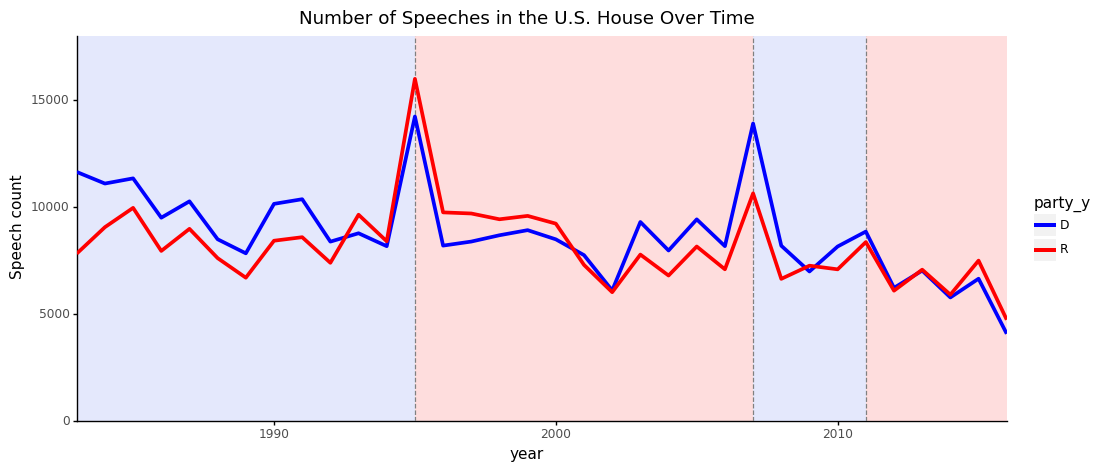

<ggplot: (-9223363273878417888)>

In [15]:
count_df = ldf.groupby(['year','party_y']).count().reset_index()
ymax = max(count_df['speech_id']) + 2000
(
ggplot(count_df,aes(x = 'year', y='speech_id',color='party_y')) + 
    annotate('rect',xmin=1983,xmax=1995,ymin=0,ymax=ymax,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=1995,xmax=2007,ymin=0,ymax=ymax,fill='#fc8f8f',alpha=0.3) + 
    annotate('rect',xmin=2007,xmax=2011,ymin=0,ymax=ymax,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=2011,xmax=2016,ymin=0,ymax=ymax,fill='#fc8f8f',alpha=0.3) + 
    annotate('segment',x=1995,xend=1995,y=0,yend=ymax,color='grey',linetype='dashed') + 
    annotate('segment',x=2007,xend=2007,y=0,yend=ymax,color='grey',linetype='dashed') + 
    annotate('segment',x=2011,xend=2011,y=0,yend=ymax,color='grey',linetype='dashed') + 
    geoms.geom_line(size=1.5) +
    scales.scale_color_manual(values=['Blue','Red']) +
    theme(panel_background=element_blank(),
          axis_line=element_line(),
         figure_size=(12,5)) +
    ylab('Speech count') +
    ggtitle("Number of Speeches in the U.S. House Over Time") +
    scales.scale_y_continuous(expand=[0,0]) +
    scales.scale_x_continuous(expand=[0,0])
)

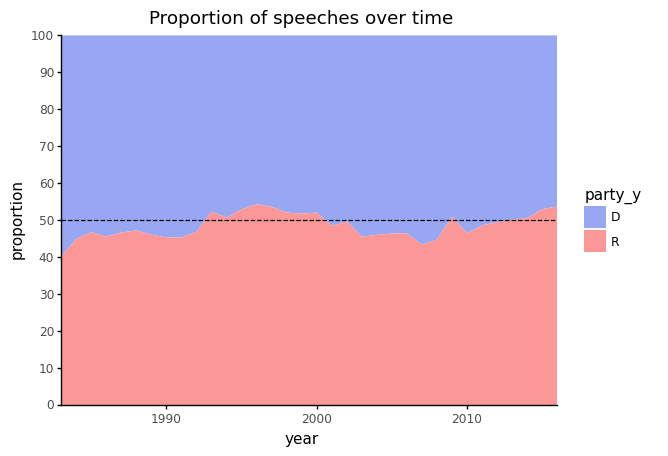

<ggplot: (8744243685917)>

In [21]:

yearly_count = ldf.groupby(['year','party_y']).agg({'party_x':'count'})
prop_speeches = yearly_count.groupby(level=0).apply(lambda x: 100*x/float(x.sum())).reset_index()

(
    ggplot(prop_speeches,aes(x='year',y='party_x',fill='party_y')) + 
    geoms.geom_area(stat='identity') +
    scales.scale_fill_manual(values=['#98a7f2','#fc9797']) +
    annotate('segment',x=1983,xend=2016,y=50,yend=50,color='black',linetype='dashed') +
    scales.scale_y_continuous(breaks=[0,10,20,30,40,50,60,70,80,90,100],expand=[0,0]) +
    theme(panel_background=element_blank(),
          axis_line=element_line()
         ) +
    scales.scale_x_continuous(expand=(0,0)) +
    ylab('proportion') +
    ggtitle('Proportion of speeches over time')
)

### Iterrogating spikes in speech frequency

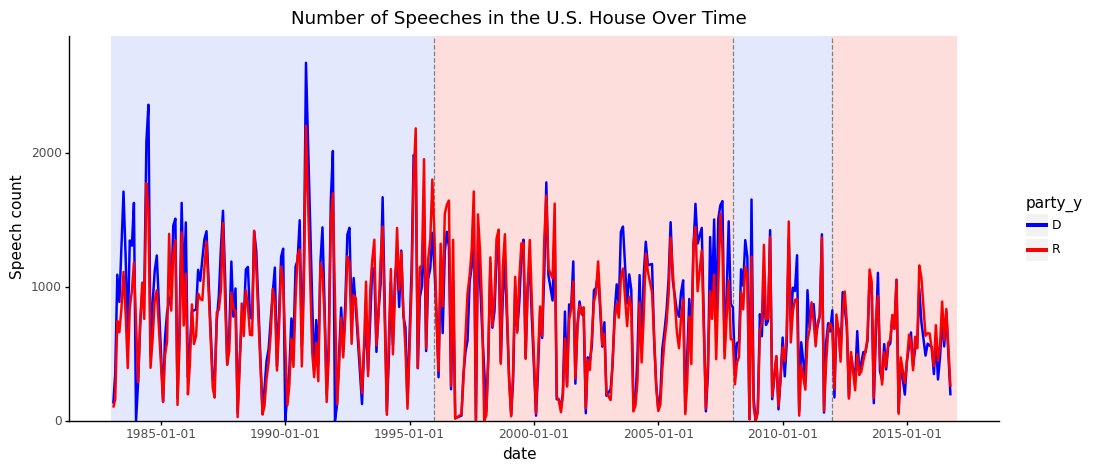

<ggplot: (8762976800383)>

In [16]:
ldf_m = ldf[['speaker','party_y','date','speech_text']]
ldf_m.index = pd.to_datetime(ldf_m['date'])
ldf_m = ldf_m.groupby([pd.Grouper(freq='M'),'party_y']).speech_text.count().reset_index()

ymax = max(ldf_m['speech_text']) + 200

(
ggplot(ldf_m,aes(x = 'date', y='speech_text',color='party_y')) + 
        annotate('rect',xmin=pd.to_datetime('1983-01-01'),xmax=pd.to_datetime('1995-12-31'),ymin=0,ymax=ymax,fill='#a5b3f7',alpha=0.3) + 
        annotate('rect',xmin=pd.to_datetime('1995-12-31'),xmax=pd.to_datetime('2007-12-31'),ymin=0,ymax=ymax,fill='#fc8f8f',alpha=0.3) + 
        annotate('rect',xmin=pd.to_datetime('2007-12-31'),xmax=pd.to_datetime('2011-12-31'),ymin=0,ymax=ymax,fill='#a5b3f7',alpha=0.3) + 
        annotate('rect',xmin=pd.to_datetime('2011-12-31'),xmax=pd.to_datetime('2016-12-31'),ymin=0,ymax=ymax,fill='#fc8f8f',alpha=0.3) + 
        annotate('segment',x=pd.to_datetime('1995-12-31'),xend=pd.to_datetime('1995-12-31'),y=0,yend=ymax,color='grey',linetype='dashed') + 
        annotate('segment',x=pd.to_datetime('2007-12-31'),xend=pd.to_datetime('2007-12-31'),y=0,yend=ymax,color='grey',linetype='dashed') + 
        annotate('segment',x=pd.to_datetime('2011-12-31'),xend=pd.to_datetime('2011-12-31'),y=0,yend=ymax,color='grey',linetype='dashed') + 
    geoms.geom_line(size=1) +
    scales.scale_color_manual(values=['Blue','Red']) +
    theme(panel_background=element_blank(),
          axis_line=element_line(),
         figure_size=(12,5)) +
    ylab('Speech count') +
    ggtitle("Number of Speeches in the U.S. House Over Time") +
    scales.scale_y_continuous(expand=[0,0]) 

)

In [17]:
indiv_count = ldf.groupby(['year','speaker','party_y']).count().reset_index()

In [18]:
indiv_avg = indiv_count.groupby(['year','party_y']).speech_id.mean().reset_index()
indiv_sd = indiv_count.groupby(['year','party_y']).speech_id.std().reset_index()

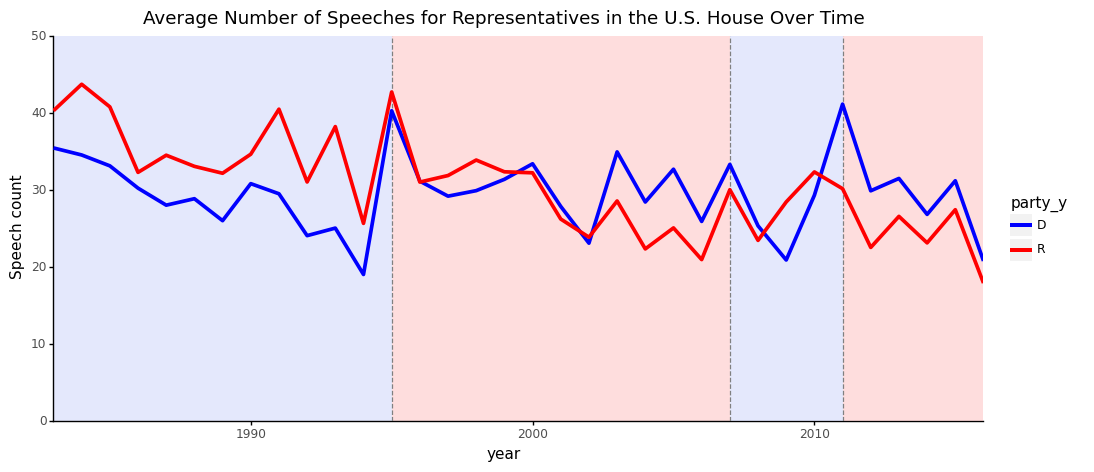

<ggplot: (8762981926271)>

In [19]:
count_df = ldf.groupby(['year','party_y']).count().reset_index()
ymin = min(indiv_avg['speech_id'])
ymax = max(indiv_avg['speech_id'])

(
ggplot(indiv_avg,aes(x = 'year', y='speech_id',color='party_y')) + 
    annotate('rect',xmin=1983,xmax=1995,ymin=0,ymax=50,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=1995,xmax=2007,ymin=0,ymax=50,fill='#fc8f8f',alpha=0.3) + 
    annotate('rect',xmin=2007,xmax=2011,ymin=0,ymax=50,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=2011,xmax=2016,ymin=0,ymax=50,fill='#fc8f8f',alpha=0.3) + 
    annotate('segment',x=1995,xend=1995,y=0,yend=50,color='grey',linetype='dashed') + 
    annotate('segment',x=2007,xend=2007,y=0,yend=50,color='grey',linetype='dashed') + 
    annotate('segment',x=2011,xend=2011,y=0,yend=50,color='grey',linetype='dashed') + 
    geoms.geom_line(size=1.5) +
    scales.scale_color_manual(values=['Blue','Red']) +
    theme(panel_background=element_blank(),
          axis_line=element_line(),
         figure_size=(12,5)) +
    ylab('Speech count') +
    ggtitle("Average Number of Speeches for Representatives in the U.S. House Over Time") +
    scales.scale_y_continuous(expand=[0,0]) +
    scales.scale_x_continuous(expand=[0,0])
)

### Who gave the most speeches in each party each year?

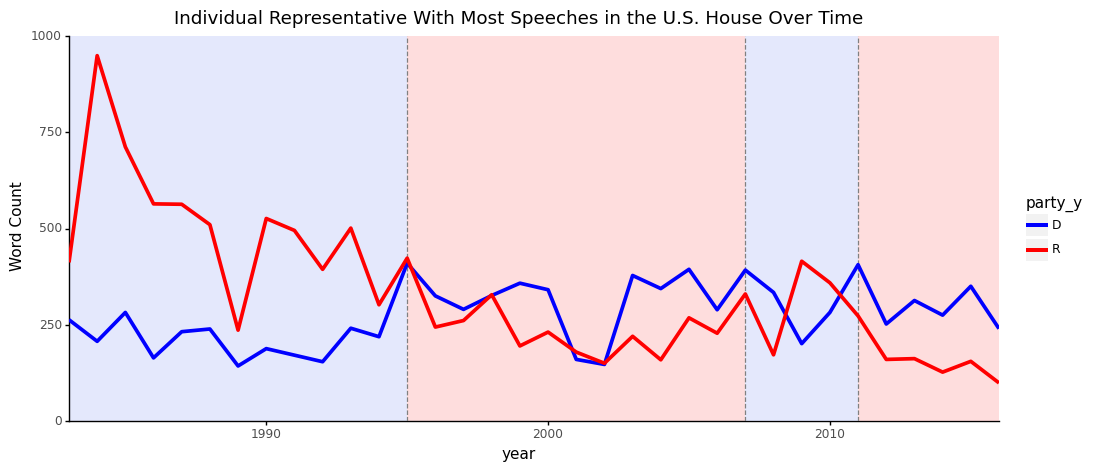

<ggplot: (8762981744690)>

In [20]:
idx = indiv_count.groupby(['year','party_y'])['speech_id'].transform(max) == indiv_count['speech_id']
max_speeches = indiv_count[idx][['year','speaker','party_y','speech_text']]

(
ggplot(max_speeches,
       aes(x = 'year', y='speech_text',color='party_y')) + 
    annotate('rect',xmin=1983,xmax=1995,ymin=0,ymax=1000,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=1995,xmax=2007,ymin=0,ymax=1000,fill='#fc8f8f',alpha=0.3) + 
    annotate('rect',xmin=2007,xmax=2011,ymin=0,ymax=1000,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=2011,xmax=2016,ymin=0,ymax=1000,fill='#fc8f8f',alpha=0.3) + 
    annotate('segment',x=1995,xend=1995,y=0,yend=1000,color='grey',linetype='dashed') + 
    annotate('segment',x=2007,xend=2007,y=0,yend=1000,color='grey',linetype='dashed') + 
    annotate('segment',x=2011,xend=2011,y=0,yend=1000,color='grey',linetype='dashed') + 
    geoms.geom_line(size=1.5) +
    scales.scale_color_manual(values=['Blue','Red']) +
    theme(panel_background=element_blank(),
          axis_line=element_line(),
         figure_size=(12,5)) +
    ylab('Word Count') +
    ggtitle("Individual Representative With Most Speeches in the U.S. House Over Time") +
    scales.scale_y_continuous(expand=[0,0]) +
    scales.scale_x_continuous(expand=[0,0])
)

In [21]:
max_speeches.pivot(index='year',columns='party_y').reset_index()

year                     speaker                                \
party_y                                 D                             R   
0        1983                  Mr. WRIGHT                    Mr. WALKER   
1        1984                  Mr. WRIGHT                    Mr. WALKER   
2        1985                   Mr. FRANK                    Mr. WALKER   
3        1986                   Mr. FOLEY                    Mr. WALKER   
4        1987                   Mr. FRANK                    Mr. WALKER   
5        1988                   Mr. VENTO                    Mr. WALKER   
6        1989               Mr. TRAFICANT                    Mr. WALKER   
7        1990               Mr. TRAFICANT                    Mr. WALKER   
8        1991                 Mr. PANETTA                    Mr. WALKER   
9        1992                 Mr. MAZZOLI                    Mr. WALKER   
10       1993                  Mr. BONIOR                    Mr. WALKER   
11       1994               Mr. TRAFICANT                    Mr. WALKER   
12       1995              Mrs. SCHROEDER                   Mr. SOLOMON   
13       1996                 Mr. PALLONE                  Mr. KINGSTON   
14       1997                 Mr. PALLONE                   Mr. SOLOMON   
15       1998    Ms. JACKSON-LEE of Texas                   Mr. SOLOMON   
16       1999    Ms. JACKSON-LEE of Texas                  Mr. SCHAFFER   
17       2000                    Mr. OBEY                    Mr. GILMAN   
18       2001                 Mr. PALLONE                    Mr. THOMAS   
19       2002                 Mr. PALLONE                     Mr. ARMEY   
20       2003    Ms. JACKSON-LEE of Texas                     Mr. DELAY   
21       2004    Ms. JACKSON-LEE of Texas                     Mr. DELAY   
22       2005    Ms. JACKSON-LEE of Texas                   Mr. GINGREY   
23       2006            Mr. RYAN of Ohio                   Mr. GINGREY   
24       2007    Ms. JACKSON-LEE of Texas          Mr. PRICE of Georgia   
25       2008    Ms. JACKSON-LEE of Texas                       Mr. POE   
26       2009  Mr. FRANK of Massachusetts                      Mr. AKIN   
27       2010               Mr. GARAMENDI                      Mr. AKIN   
28       2011    Ms. JACKSON LEE of Texas                    Mr. DREIER   
29       2012    Ms. JACKSON LEE of Texas    Mr. HASTINGS of Washington   
30       2013             Ms. JACKSON LEE                      Ms. FOXX   
31       2014             Ms. JACKSON LEE    Mr. HASTINGS of Washington   
32       2015             Ms. JACKSON LEE  Mr. THOMPSON of Pennsylvania   
33       2016             Ms. JACKSON LEE  Mr. THOMPSON of Pennsylvania   

        speech_text       
party_y           D    R  
0               263  412  
1               207  949  
2               282  712  
3               164  564  
4               232  563  
5               239  510  
6               143  236  
7               188  526  
8               171  495  
9               154  394  
10              241  501  
11              219  302  
12              410  423  
13              325  244  
14              290  261  
15              326  328  
16              358  195  
17              341  231  
18              160  179  
19              147  150  
20              378  220  
21              344  159  
22              394  268  
23              289  228  
24              392  330  
25              334  172  
26              201  415  
27              282  359  
28              406  273  
29              252  160  
30              313  162  
31              275  127  
32              350  155  
33              240   99

Uh Oh... Noticing here that there is some significnat mislabeling of representatives party identification... This is a big issue and needs to be addressed. 

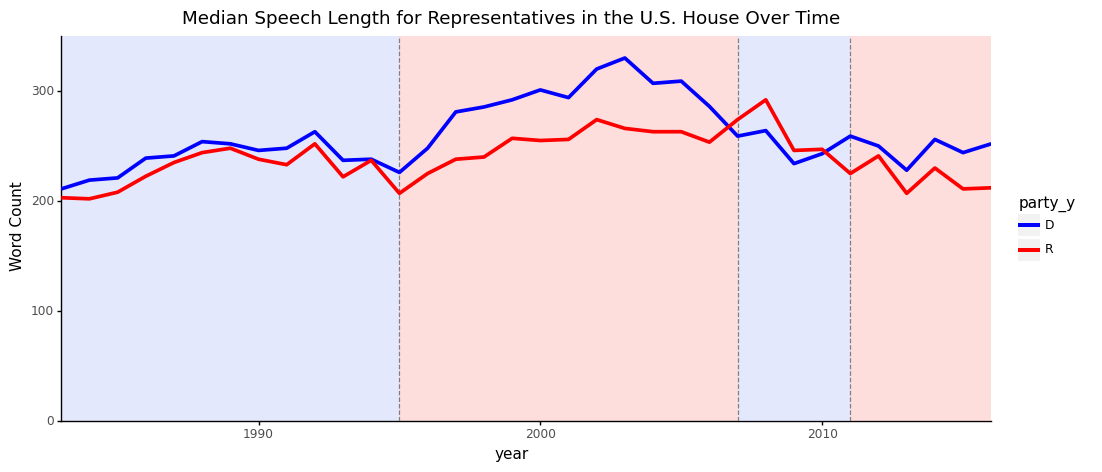

<ggplot: (8762981714482)>

In [22]:

(
ggplot(ldf.groupby(['year','party_y']).word_count.median().reset_index(),
       aes(x = 'year', y='word_count',color='party_y')) + 
    annotate('rect',xmin=1983,xmax=1995,ymin=0,ymax=350,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=1995,xmax=2007,ymin=0,ymax=350,fill='#fc8f8f',alpha=0.3) + 
    annotate('rect',xmin=2007,xmax=2011,ymin=0,ymax=350,fill='#a5b3f7',alpha=0.3) + 
    annotate('rect',xmin=2011,xmax=2016,ymin=0,ymax=350,fill='#fc8f8f',alpha=0.3) + 
    annotate('segment',x=1995,xend=1995,y=0,yend=350,color='grey',linetype='dashed') + 
    annotate('segment',x=2007,xend=2007,y=0,yend=350,color='grey',linetype='dashed') + 
    annotate('segment',x=2011,xend=2011,y=0,yend=350,color='grey',linetype='dashed') + 
    geoms.geom_line(size=1.5) +
    scales.scale_color_manual(values=['Blue','Red']) +
    theme(panel_background=element_blank(),
          axis_line=element_line(),
         figure_size=(12,5)) +
    ylab('Word Count') +
    ggtitle("Median Speech Length for Representatives in the U.S. House Over Time") +
    scales.scale_y_continuous(expand=[0,0]) +
    scales.scale_x_continuous(expand=[0,0])
)